In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output

%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

print(check_output(["ls", "./"]).decode("utf8"))

df_train = pd.read_csv("./train.csv").fillna("")
df_train.head() 

char_embed.txt
data analysis.ipynb
question.csv
test.csv
train.csv
word_embed.txt



,label,q1,q2
0,1,Q397345,Q538594
1,0,Q193805,Q699273
2,0,Q085471,Q676160
3,0,Q189314,Q438123
4,0,Q267714,Q290126


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254386 entries, 0 to 254385
Data columns (total 3 columns):
label    254386 non-null int64
q1       254386 non-null object
q2       254386 non-null object
dtypes: int64(1), object(2)
memory usage: 5.8+ MB


In [6]:
df_test = pd.read_csv("./test.csv").fillna("")
df_test.head() 

,q1,q2
0,Q017571,Q006012
1,Q728241,Q542572
2,Q166997,Q118270
3,Q422420,Q514386
4,Q354329,Q032485


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172956 entries, 0 to 172955
Data columns (total 2 columns):
q1    172956 non-null object
q2    172956 non-null object
dtypes: object(2)
memory usage: 2.6+ MB


下面看看训练数据分布情况

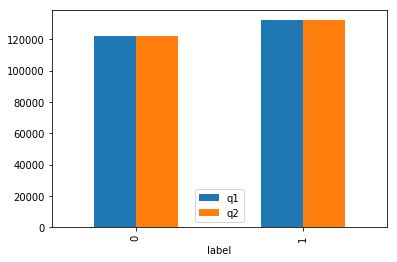

In [9]:
df_train.groupby('label').count().plot.bar()

In [11]:
df_questions = pd.read_csv('./question.csv').fillna("")
df_questions.head() 

,qid,words,chars
0,Q000000,W05733 W05284 W09158 W14968 W07863,L1128 L1861 L2218 L1796 L1055 L0847 L2927
1,Q000001,W17378 W17534 W03249 W01490 W18802,L2214 L1980 L0156 L1554 L2218 L1861 L3019 L010...
2,Q000002,W17378 W08158 W20171 W11246 W14759,L2214 L2350 L2568 L1969 L2168 L0694 L3012 L256...
3,Q000003,W11385 W14103 W02556 W13157 W09749,L0762 L2172 L1971 L2034 L2039 L2271 L1346 L223...
4,Q000004,W17508 W18238 W02952 W18103,L0018 L2321 L1346 L3019 L0104 L0902 L0354 L0362


#### merge

In [16]:
df = pd.merge(df_train, df_questions, how='left', left_on='q1', right_on='qid')
df.rename(columns={'words':'word_q1', 'chars':'char_q1'}, inplace=True) 

df = pd.merge(df, df_questions, how='left', left_on='q2', right_on='qid')
df.rename(columns={'words':'word_q2', 'chars':'char_q2'}, inplace=True) 
df.head()

,label,q1,q2,qid_x,word_q1,char_q1,qid_y,word_q2,char_q2
0,1,Q397345,Q538594,Q397345,W04465 W04058 W05284 W02916,L2218 L2568 L0360 L0242 L2218 L0741,Q538594,W18238 W18843 W01490 W09905,L3019 L0104 L0582 L2218 L1861 L1556 L0242
1,0,Q193805,Q699273,Q193805,W10054 W04476 W09996 W12244 W18103,L2376 L2168 L0050 L1187 L0104 L2432 L0902 L014...,Q699273,W18439 W00863 W04259 W00740 W16070,L0156 L2452 L1187 L0104 L2459 L2979 L2613 L0449
2,0,Q085471,Q676160,Q085471,W04346 W17378 W19355 W17926 W14185 W11567 W07863,L2323 L1526 L2214 L1132 L2723 L1861 L2249 L050...,Q676160,W14586 W09745 W06017 W09067 W16319,L2568 L0971 L1291 L0358 L0037 L2582
3,0,Q189314,Q438123,Q189314,W17508 W09996 W19662 W17534 W11399 W17057 W182...,L0018 L2321 L1346 L2432 L0902 L1149 L1980 L187...,Q438123,W18238 W02357 W06606,L3019 L0104 L1104 L1935 L1683 L2495 L2812
4,0,Q267714,Q290126,Q267714,W13157 W03390 W01952 W05789 W17378 W08714 W13157,L2271 L1346 L1389 L2932 L0466 L2218 L1971 L221...,Q290126,W04476 W06606 W00316 W13157,L0050 L1187 L0104 L1683 L2495 L2812 L1588 L255...


In [19]:
df.shape

(254386, 9)

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer

tf_idf = TfidfVectorizer(max_features = 128).fit_transform(df['word_q1'].values)

tf_idf

<254386x128 sparse matrix of type '<class 'numpy.float64'>'
	with 1036818 stored elements in Compressed Sparse Row format>

In [21]:
tf_idf_2 = TfidfVectorizer(max_features = 128).fit_transform(df['word_q2'].values)

In [22]:
diff = tf_idf - tf_idf_2

In [23]:
diff[:10]

<10x128 sparse matrix of type '<class 'numpy.float64'>'
	with 71 stored elements in Compressed Sparse Row format>

#### 3D t-SNE embedding

In [27]:
from sklearn.manifold import TSNE
tsne = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=250,
    verbose=2,
    angle=0.5
).fit_transform(diff[:5000].toarray())

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.085s...
[t-SNE] Computed neighbors for 5000 samples in 7.223s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.435924
[t-SNE] Computed conditional probabilities in 0.196s
[t-SNE] Iteration 50: error = 125.5571442, gradient norm = 0.2121896 (50 iterations in 28.548s)
[t-SNE] Iteration 100: error = 134.7404022, gradient norm = 0.0248587 (50 iterations in 26.870s)
[t-SNE] Iteration 150: error = 138.2619019, gradient norm = 0.0185413 (50 iterations in 18.174s)
[t-SNE] Iteration 200: error = 142.6337585, gradient norm = 0.0046551 (50 iterations in 16.335s)
[t-SNE] Iteration 250: error = 142.1504974, gradient norm = 

In [29]:
trace1 = go.Scatter3d(
    x=tsne[:,0],
    y=tsne[:,1],
    z=tsne[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = df[:5000]['label'].values,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='test')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

#### Feature EDA

In [32]:
df['q1_word_num'] = df['word_q1'].apply(lambda text: len(text.split(' ')))
df['q2_word_num'] = df['word_q2'].apply(lambda text: len(text.split(' ')))

df['q1_char_num'] = df['char_q1'].apply(lambda text: len(text.split(' ')))
df['q2_char_num'] = df['char_q2'].apply(lambda text: len(text.split(' ')))

df[:1]

,label,q1,q2,qid_x,word_q1,char_q1,qid_y,word_q2,char_q2,q1_word_num,q2_word_num,q1_char_num,q2_char_num
0,1,Q397345,Q538594,Q397345,W04465 W04058 W05284 W02916,L2218 L2568 L0360 L0242 L2218 L0741,Q538594,W18238 W18843 W01490 W09905,L3019 L0104 L0582 L2218 L1861 L1556 L0242,4,4,6,7


In [34]:
# 共享词
def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['word_q1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['word_q2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))

df['word_share'] = df.apply(normalized_word_share, axis=1)

df['word_share'][:10]

0    0.000000
1    0.000000
2    0.000000
3    0.090909
4    0.100000
5    0.181818
6    0.000000
7    0.000000
8    0.083333
9    0.000000
Name: word_share, dtype: float64

In [36]:
# 共享字
def normalized_char_share(row):
    c1 = set(map(lambda char: char.lower().strip(), row['char_q1'].split(" ")))
    c2 = set(map(lambda char: char.lower().strip(), row['char_q2'].split(" ")))    
    return 1.0 * len(c1 & c2)/(len(c1) + len(c2))

df['char_share'] = df.apply(normalized_char_share, axis=1)

df['char_share'][:10]

0    0.166667
1    0.111111
2    0.000000
3    0.095238
4    0.100000
5    0.277778
6    0.055556
7    0.000000
8    0.227273
9    0.034483
Name: char_share, dtype: float64

D:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.

D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



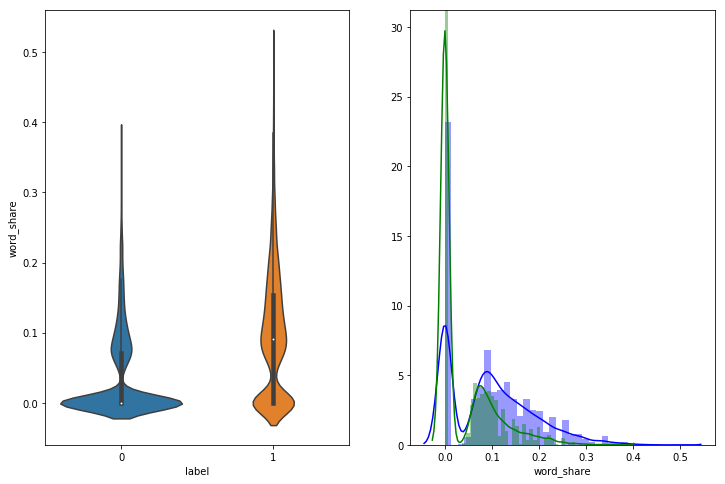

In [41]:
# word share
plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
sns.violinplot(x='label', y='word_share', data=df[:10000])

plt.subplot(1, 2, 2)
sns.distplot(df[df['label'] == 1]['word_share'][:10000], color='blue')
sns.distplot(df[df['label'] == 0]['word_share'][:10000], color='green')

D:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.

D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



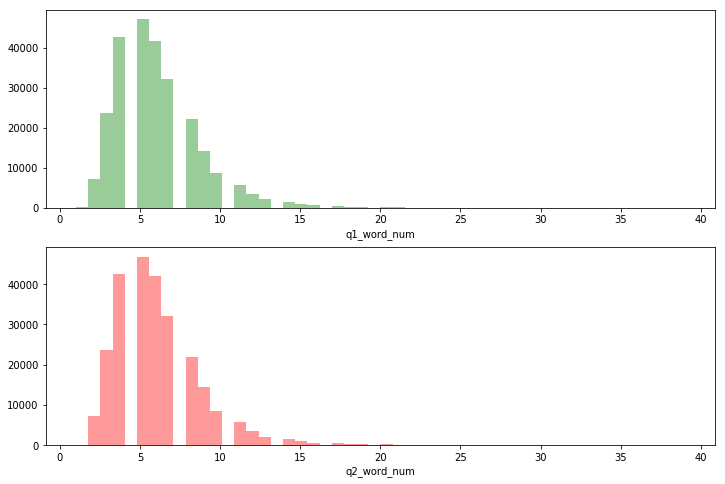

In [48]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
sns.distplot(df['q1_word_num'], kde=False, color='green')

plt.subplot(2, 1, 2)
sns.distplot(df['q2_word_num'], kde=False, color='red')

In [53]:
df_subsampled = df[0:2000]

trace = go.Scatter(
    y = df_subsampled['q2_char_num'].values,
    x = df_subsampled['q1_char_num'].values,
    mode='markers',
    marker=dict(
        size= df_subsampled['word_share'].values * 60,
        color = df_subsampled['label'].values,
        colorscale='Portland',
        showscale=True,
        opacity=0.5,
        colorbar = dict(title = 'duplicate')
    ),
    text = np.round(df_subsampled['word_share'].values, decimals=2)
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Scatter plot of character lengths of question one and two',
    hovermode= 'closest',
        xaxis=dict(
        showgrid=False,
        zeroline=False,
        showline=False
    ),
    yaxis=dict(
        title= 'Question 2 length',
        ticklen= 5,
        gridwidth= 2,
        showgrid=False,
        zeroline=False,
        showline=False,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatterWords')

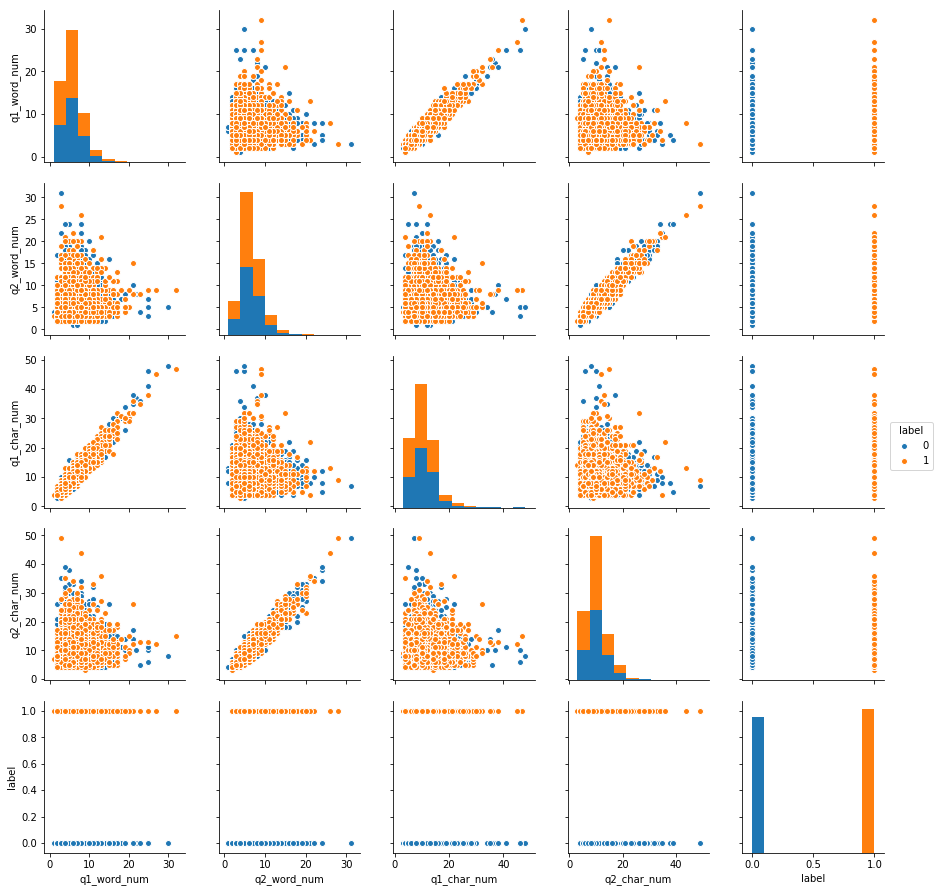

In [54]:
n = 10000
sns.pairplot(df[['q1_word_num', 'q2_word_num', 'q1_char_num', 'q2_char_num', 'label']][0:n], hue='label')

In [56]:
import sys

# 寻找相似问题子集
q1 = df["q1"].values
q2 = df["q2"].values
label = df["label"].values

rows = q1.shape[0]
dict_1 = dict()

# 将所有相似的q[i]合并
for i in range(0,rows):
    if label[i] == 1:                   # 相似
        if dict_1.get(q1[i],-1) == -1:  # q1不在dict_1中
            dict_1[q1[i]] = [q2[i]]     # {q1:[q2]}
        else:                           # q1在dict_1中
            dict_1[q1[i]].append(q2[i]) # {q1:[q2, q2]}

        if dict_1.get(q2[i],-1) == -1:
            dict_1[q2[i]] = [q1[i]]
        else:
            dict_1[q2[i]].append(q1[i])

    if i%5000 == 0:            # 每5000rows，打印一个#
        sys.stdout.flush()     # 刷新stdout, 不会一次性输出打印结果
        sys.stdout.write("#")  # 把字符写到标准输出中

print(len(dict_1))

###################################################123370


In [75]:
df_sim = pd.DataFrame.from_dict(dict_1, orient='index')
df_sim.info()

<class 'pandas.core.frame.DataFrame'>
Index: 123370 entries, Q397345 to Q506804
Data columns (total 99 columns):
0     123370 non-null object
1     24161 non-null object
2     12432 non-null object
3     10035 non-null object
4     8391 non-null object
5     7028 non-null object
6     5975 non-null object
7     5166 non-null object
8     4489 non-null object
9     3975 non-null object
10    3553 non-null object
11    3209 non-null object
12    2917 non-null object
13    2686 non-null object
14    2498 non-null object
15    2322 non-null object
16    2172 non-null object
17    2055 non-null object
18    1941 non-null object
19    1834 non-null object
20    1728 non-null object
21    1625 non-null object
22    1538 non-null object
23    1449 non-null object
24    1363 non-null object
25    1281 non-null object
26    1208 non-null object
27    1162 non-null object
28    1109 non-null object
29    1060 non-null object
30    1022 non-null object
31    982 non-null object
32    950 non-null 

In [80]:
df_sim.head()

,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
Q397345,Q538594,Q458620,Q105468,Q354445,Q448052,Q173464,Q189249,Q536356,Q690901,Q075159,...,None,None,None,None,None,None,None,None,None,None
Q538594,Q397345,Q482314,Q127625,Q448259,Q466742,Q299397,Q260824,None,None,None,...,None,None,None,None,None,None,None,None,None,None
Q369715,Q658908,Q076371,Q145433,Q279452,Q709988,Q647379,Q442484,Q336306,Q284124,Q596188,...,None,None,None,None,None,None,None,None,None,None
Q658908,Q369715,Q238765,Q408167,Q657608,Q009592,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
Q537991,Q268444,Q709091,Q176289,Q247561,Q440508,Q411085,Q030390,Q204888,Q127170,Q030047,...,None,None,None,None,None,None,None,None,None,None
